In [1]:
 pip install -Uqq fastai duckduckgo_search

Note: you may need to restart the kernel to use updated packages.


In [2]:
#step 1: download images of birds and non-birds

In [3]:
from fastbook import *

In [4]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    with DDGS() as ddgs:
        search_results = ddgs.images(keywords=term)
        image_urls = [result.get("image") for result in search_results[:max_images]]   
    return L(image_urls)

In [8]:
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 'food photos'


'https://images.pexels.com/photos/1633578/pexels-photo-1633578.jpeg?cs=srgb&dl=beef-bread-buns-1633578.jpg&fm=jpg'

In [9]:
from fastdownload import download_url

from fastai.vision.all import *


In [10]:
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

Path('food.jpg')

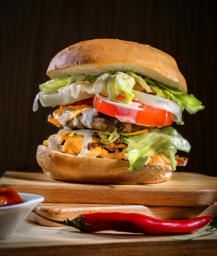

In [11]:
im = Image.open(dest)
im.to_thumb(256, 256)

In [16]:
searches = "forest", "bird"
path = Path("bird_or_not")

from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'hotdog photo'
Searching for 'hotdog top view photo'
Searching for 'hotdog side view photo'


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Searching for 'food except hot dog photo'
Searching for 'food except hot dog top view photo'
Searching for 'food except hot dog side view photo'


In [ ]:
#step 2: train our model

In [17]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

29

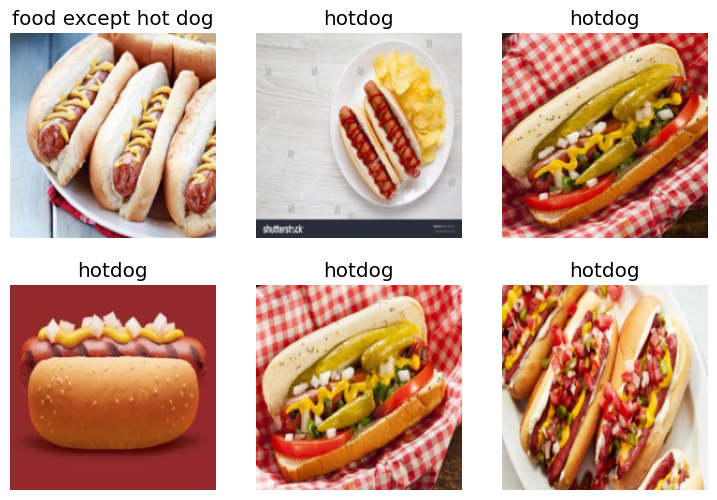

In [18]:
dls = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method="squish")]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [19]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/khushimittal/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████| 44.7M/44.7M [00:03<00:00, 13.0MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.355603,0.002508,0.000000,00:18


epoch,train_loss,valid_loss,error_rate,time
0,0.018077,0.000056,0.000000,00:10
1,0.008777,0.000257,0.000000,00:08
2,0.006392,0.000106,0.000000,00:08


In [20]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")


This is a: bird.
Probability it's a bird: 0.9999
